## Downloading PDB and CIF files from Alphafold

In [3]:
pip install py3Dmol

Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
import pandas as pd
import py3Dmol


In [2]:
#code to download Alphafold files directly into Cyverse

# Replace with the UniProt ID of your protein
uniprot_id = "P68871"  

#URL for CIF downloads
url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.cif"

#code to download CIF file
response = requests.get(url)
if response.status_code == 200:
    with open(f"{uniprot_id}.cif", "wb") as file:
        file.write(response.content)
    print(f"CIF file for {uniprot_id} downloaded successfully.")
else:
    print(f"Failed to download CIF file. Status code: {response.status_code}")

#URL for PDB downloads
url = f"https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb"

#code to download PDB file
response = requests.get(url)
if response.status_code == 200:
    with open(f"{uniprot_id}.pdb", "wb") as file:
        file.write(response.content)
    print(f"PDB file for {uniprot_id} downloaded successfully.")
else:
    print(f"Failed to download PDB file. Status code: {response.status_code}")

CIF file for P68871 downloaded successfully.
PDB file for P68871 downloaded successfully.


In [3]:
# Use py3Dmol to visualize your PDB file
with open("P68871.pdb", "r") as file:
    pdb_data = file.read()

# Create viewer and load the PDB data
view = py3Dmol.view(width=400, height=300)
view.addModel(pdb_data, "pdb")
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Using Gemmi to Parse the cif files for Structural Info

In [5]:
pip install gemmi

     |████████████████████████████████| 2.6 MB 3.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
from gemmi import cif

In [7]:
#load in CIF file using Gemmi
doc = cif.read(f"{uniprot_id}.cif")

In [8]:
#Parse CIF file for 3D coordinate info
block = doc.sole_block()
atom_id = block.find_loop('_atom_site.label_atom_id')
residue_id = block.find_loop('_atom_site.label_comp_id')
residue_num = block.find_loop('_atom_site.label_seq_id')
x_coord = block.find_loop('_atom_site.Cartn_x')
y_coord = block.find_loop('_atom_site.Cartn_y')
z_coord = block.find_loop('_atom_site.Cartn_z')

#convert gemmi objects to lists
atom_id = [i for i in atom_id]
residue_id = [i for i in residue_id]
residue_num = [i for i in residue_num]
x_coord = [eval(i) for i in x_coord] 
y_coord = [eval(i) for i in y_coord] 
z_coord = [eval(i) for i in z_coord] 

#turn lists into Pandas Dataframe
xyz_coord_dic = {'atom_id':atom_id,'residue_id':residue_id,'residue_num':residue_num,'x_coord':x_coord, 'y_coord':y_coord, 'z_coord':z_coord}
xyz_coord_df = pd.DataFrame(xyz_coord_dic)

In [9]:
#load df
xyz_coord_df

,atom_id,residue_id,residue_num,x_coord,y_coord,z_coord
0,N,MET,1,4.394,7.158,16.767
1,CA,MET,1,3.187,6.337,16.975
2,C,MET,1,2.050,7.105,16.336
3,CB,MET,1,2.972,6.116,18.481
4,O,MET,1,2.015,8.315,16.535
...,...,...,...,...,...,...
1126,CD2,HIS,147,22.192,1.406,10.440
1127,ND1,HIS,147,20.010,1.280,10.191
1128,CE1,HIS,147,20.518,0.044,10.066
1129,NE2,HIS,147,21.844,0.061,10.266


In [10]:
#Parse CIF file for structural info
block = doc.sole_block()
res_id = block.find_loop('_struct_conf.beg_auth_comp_id')
res_num = block.find_loop('_struct_conf.beg_auth_seq_id')
structural_motif = block.find_loop('_struct_conf.conf_type_id')


#convert gemmi objects to lists
res_id = [i for i in res_id]
res_num = [i for i in res_num]
structural_motif = [i for i in structural_motif]
 

#turn lists into Pandas Dataframe
structural_info_dic = {'res_id':res_id,'res_num':res_num,'structural_motif':structural_motif}
structural_info_df = pd.DataFrame(structural_info_dic)

In [11]:
#load df
structural_info_df

,res_id,res_num,structural_motif
0,PRO,6,HELX_RH_AL_P
1,GLY,17,TURN_TY1_P
2,VAL,21,HELX_RH_AL_P
3,TYR,36,BEND
4,PRO,37,HELX_RH_3T_P
5,SER,50,BEND
6,PRO,52,HELX_RH_AL_P
7,PRO,59,HELX_RH_AL_P
8,HIS,78,TURN_TY1_P
9,LEU,79,HELX_RH_3T_P


## Making Ramachandran Plots

In [12]:
from Bio import PDB
from Bio.PDB import calc_dihedral
from math import degrees
import matplotlib.pyplot as plt

In [13]:
# Path to your PDB file
pdb_file = "P68871.pdb"

In [14]:
# Create a PDB parser and structure object
parser = PDB.PDBParser(QUIET=True)
structure = parser.get_structure("protein", pdb_file)

In [15]:
#Function to calculate phi and psi angles
def get_phi_psi_angles(structure):
    phi_psi_angles = []
    for model in structure:
        for chain in model:
            residues = list(chain)
            for i, residue in enumerate(residues):
                # Skip residues without backbone atoms
                if not residue.has_id("N") or not residue.has_id("CA") or not residue.has_id("C"):
                    continue
                
                # Calculate phi (ϕ) if the previous residue exists
                if i > 0:
                    prev_residue = residues[i - 1]
                    if prev_residue.has_id("C"):
                        n = residue["N"].get_vector()
                        ca = residue["CA"].get_vector()
                        c = residue["C"].get_vector()
                        c_prev = prev_residue["C"].get_vector()
                        phi = calc_dihedral(c_prev, n, ca, c)
                        phi_psi_angles.append((degrees(phi), None))  # Store φ angle
                
                # Calculate psi (ψ) if the next residue exists
                if i < len(residues) - 1:
                    next_residue = residues[i + 1]
                    if next_residue.has_id("N"):
                        n_next = next_residue["N"].get_vector()
                        ca = residue["CA"].get_vector()
                        c = residue["C"].get_vector()
                        n = residue["N"].get_vector()
                        psi = calc_dihedral(n, ca, c, n_next)
                        if len(phi_psi_angles) > 0 and phi_psi_angles[-1][1] is None:
                            phi_psi_angles[-1] = (phi_psi_angles[-1][0], degrees(psi))  # Update ψ angle
    return phi_psi_angles

In [16]:
# Use function to calculate phi psi angles
phi_psi_angles = get_phi_psi_angles(structure)

In [17]:
# Extract phi and psi angles
phi_angles, psi_angles = zip(*phi_psi_angles)

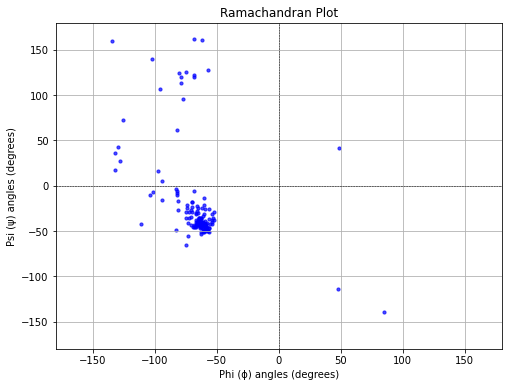

In [18]:
# Plot basic Ramachandran plot
plt.figure(figsize=(8, 6))
plt.scatter(phi_angles, psi_angles, s=10, color="blue", alpha=0.7)
plt.title("Ramachandran Plot")
plt.xlabel("Phi (ϕ) angles (degrees)")
plt.ylabel("Psi (ψ) angles (degrees)")
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.grid(True)
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
plt.show()